In [100]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import mysql.connector
import json
from collections import Counter
import os
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from dowhy import CausalModel
import re
from scipy.spatial.distance import jensenshannon
from dotenv import load_dotenv
import warnings
load_dotenv()

# NumPy関連のRuntimeWarningを無効化
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [103]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [120]:
targets=[
    ["tomato", "basil", "mozzarella cheese", "olive oil", "bread"],
    ["oyster", "cucumber", "ginger", "soy sauce"],
    ["lettuce", "tomato", "cucumber", "pig", "bread"],
]

def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_sub_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, node.flavor_vector as flavor_vector, score    
    """
    return tx.run(find_food_query, search_term=search_term).data()

    
with driver.session() as session:
    for dish in targets:
        ar_result = []
        for target in dish:
            result1 = session.execute_read(find_food, target)  
            ar_result.append(result1[0])
        
        pd_result = pd.DataFrame(ar_result)
        pd_result.set_index('node_id', inplace=True)
        pd_result = pd_result.transpose()
        
        # 材料のペアを生成
        ingredients = list(pd_result.keys())
        pairs = list(combinations(ingredients, 2))
        
        # 類似度を計算
        cosine_similarities = []
        jsd_similarities = []

        for ing1, ing2 in pairs:
            vector1 = np.array(pd_result[ing1]['flavor_vector']).reshape(1, -1)
            vector2 = np.array(pd_result[ing2]['flavor_vector']).reshape(1, -1)
    
            try:
                # Check if vector1 or vector2 contains NaN
                np.isnan(vector1).any()
                np.isnan(vector2).any()
            except Exception as e:
                # Print ingredient names and vector2 for debugging
                print("Error occurred while checking for NaN:")
                print("Ingredient 1:", ing1)
                print("Ingredient 2:", ing2)
                print("Vector1:", vector1)
                print("Vector2:", vector2)
                print("Exception:", str(e))

            # コサイン類似度
            cosine_sim = cosine_similarity(vector1, vector2)[0, 0]
            cosine_similarities.append(cosine_sim)
            
            # ジェンセン・シャノン距離（類似度に変換）
            jsd = 1 - jensenshannon(vector1, vector2)
            jsd_similarities.append(jsd)

        # 各類似度の平均を計算
        cosine_similarity_score = np.mean(cosine_similarities)
        jsd_similarity_score = np.mean(jsd_similarities)
        # 結果を表示
        print(f"Cosine Pairwise Similarities: {dict(zip(pairs, cosine_similarities))}")
        #print(f"JSD Pairwise Similarities: {dict(zip(pairs, jsd_similarities))}")
        print(f"Cosine Similarity Score: {cosine_similarity_score}")
        #print(f"JSD Similarity Score: {jsd_similarity_score}")
        print("-------------")

Cosine Pairwise Similarities: {('tomato', 'basil'): 0.9454471773960327, ('tomato', 'cheese_mozzarella_nonfat'): 0.0, ('tomato', 'olive_oil'): 0.2094876620013364, ('tomato', 'bread_stuffing_bread_dry_mix'): 0.9689307248598799, ('basil', 'cheese_mozzarella_nonfat'): 0.0, ('basil', 'olive_oil'): 0.07146644121415621, ('basil', 'bread_stuffing_bread_dry_mix'): 0.9877694601745097, ('cheese_mozzarella_nonfat', 'olive_oil'): 0.0, ('cheese_mozzarella_nonfat', 'bread_stuffing_bread_dry_mix'): 0.0, ('olive_oil', 'bread_stuffing_bread_dry_mix'): 0.18203142116582585}
Cosine Similarity Score: 0.336513288681174
-------------
Cosine Pairwise Similarities: {('oyster_raw', 'cucumber'): 0.27472820700585343, ('oyster_raw', 'ginger'): 0.4125458823429973, ('oyster_raw', 'soy_sauce'): 0.4787660520074942, ('cucumber', 'ginger'): 0.6910617585441017, ('cucumber', 'soy_sauce'): 0.1726228102817007, ('ginger', 'soy_sauce'): 0.19203520090745616}
Cosine Similarity Score: 0.37029331851493397
-------------
Cosine Pair

## 1. 仮説の明確化
仮説は次のように定義します：

同じ芳香成分を多く含む食材を組み合わせたレシピは、評価（rating）が高くなる傾向がある。

原因（Treatment）: 材料同士が共有する芳香成分の類似度。
結果（Outcome）: レシピの評価（rating）。
共変量（Confounder）: レシピの難易度、調理時間、人気のジャンルなど、評価に影響を与える可能性のある変数。

## 2. データの準備
以下のようなデータを収集・構築します：

### 2.1 レシピデータ
各レシピの名前、評価（rating）、材料リスト、調理手順など。
### 2.2 材料と芳香成分のデータ
各材料が含む芳香成分のベクトル表現（例: buttermilk: {'bitter': 0.249, 'baked': 0.138, ...}）。
### 2.3 芳香成分の類似度計算
レシピ内の材料同士の類似度を計算。
類似度は次のように計算できます：
コサイン類似度（香りベクトル間の角度を評価）
共通成分のスコア合計（共通する成分のスコアの和）
例: レシピ内の全材料の類似度平均を算出。

## 3. 因果モデルの構築
3.1 モデルの設定
Treatment（原因）: レシピ内の材料間の芳香成分類似度の平均スコア。
Outcome（結果）: レシピの評価（rating）。
Confounders（共変量）: 他の要因（例: レシピのジャンル、難易度、調理時間）。

## 5. 仮説の検証
成果物の例:
因果効果: 材料間の芳香成分類似度が高い場合、評価が平均で0.3ポイント高くなる。
検証結果: 推定結果に基づき仮説を支持または棄却する。

In [ ]:
### サンプルコード

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import numpy as np
from itertools import combinations

# 成分データ（円グラフをベクトル化）
flavor_vectors = {
    "tomato": np.array([0.2, 0.3, 0.5, 0.0, 0.1]),
    "basil": np.array([0.1, 0.4, 0.3, 0.2, 0.0]),
    "mozzarella cheese": np.array([0.5, 0.1, 0.0, 0.4, 0.0]),
    "olive oil": np.array([0.3, 0.2, 0.1, 0.0, 0.4])
}

# 材料のペアを生成
ingredients = list(flavor_vectors.keys())
pairs = list(combinations(ingredients, 2))

# 類似度を計算
cosine_similarities = []
jsd_similarities = []

for ing1, ing2 in pairs:
    vector1 = flavor_vectors[ing1].reshape(1, -1)
    vector2 = flavor_vectors[ing2].reshape(1, -1)
    
    # コサイン類似度
    cosine_sim = cosine_similarity(vector1, vector2)[0, 0]
    cosine_similarities.append(cosine_sim)
    
    # ジェンセン・シャノン距離（類似度に変換）
    jsd = 1 - jensenshannon(flavor_vectors[ing1], flavor_vectors[ing2])
    jsd_similarities.append(jsd)

# 各類似度の平均を計算
cosine_similarity_score = np.mean(cosine_similarities)
jsd_similarity_score = np.mean(jsd_similarities)

# 結果を表示
print(f"Cosine Pairwise Similarities: {dict(zip(pairs, cosine_similarities))}")
print(f"JSD Pairwise Similarities: {dict(zip(pairs, jsd_similarities))}")
print(f"Cosine Similarity Score: {cosine_similarity_score}")
print(f"JSD Similarity Score: {jsd_similarity_score}")


Cosine Pairwise Similarities: {('tomato', 'basil'): 0.8478227519967948, ('tomato', 'mozzarella cheese'): 0.3212080372198105, ('tomato', 'olive oil'): 0.6139406135149204, ('basil', 'mozzarella cheese'): 0.4789207443461594, ('basil', 'olive oil'): 0.46666666666666656, ('mozzarella cheese', 'olive oil'): 0.47892074434615933}
JSD Pairwise Similarities: {('tomato', 'basil'): 0.652333443094906, ('tomato', 'mozzarella cheese'): 0.37785175479487165, ('tomato', 'olive oil'): 0.6478621510402297, ('basil', 'mozzarella cheese'): 0.5081423361102695, ('basil', 'olive oil'): 0.47344623045316825, ('mozzarella cheese', 'olive oil'): 0.42289969671422756}
Cosine Similarity Score: 0.5345799263484184
JSD Similarity Score: 0.5137559353679454


## 

## Word2Vec可視化

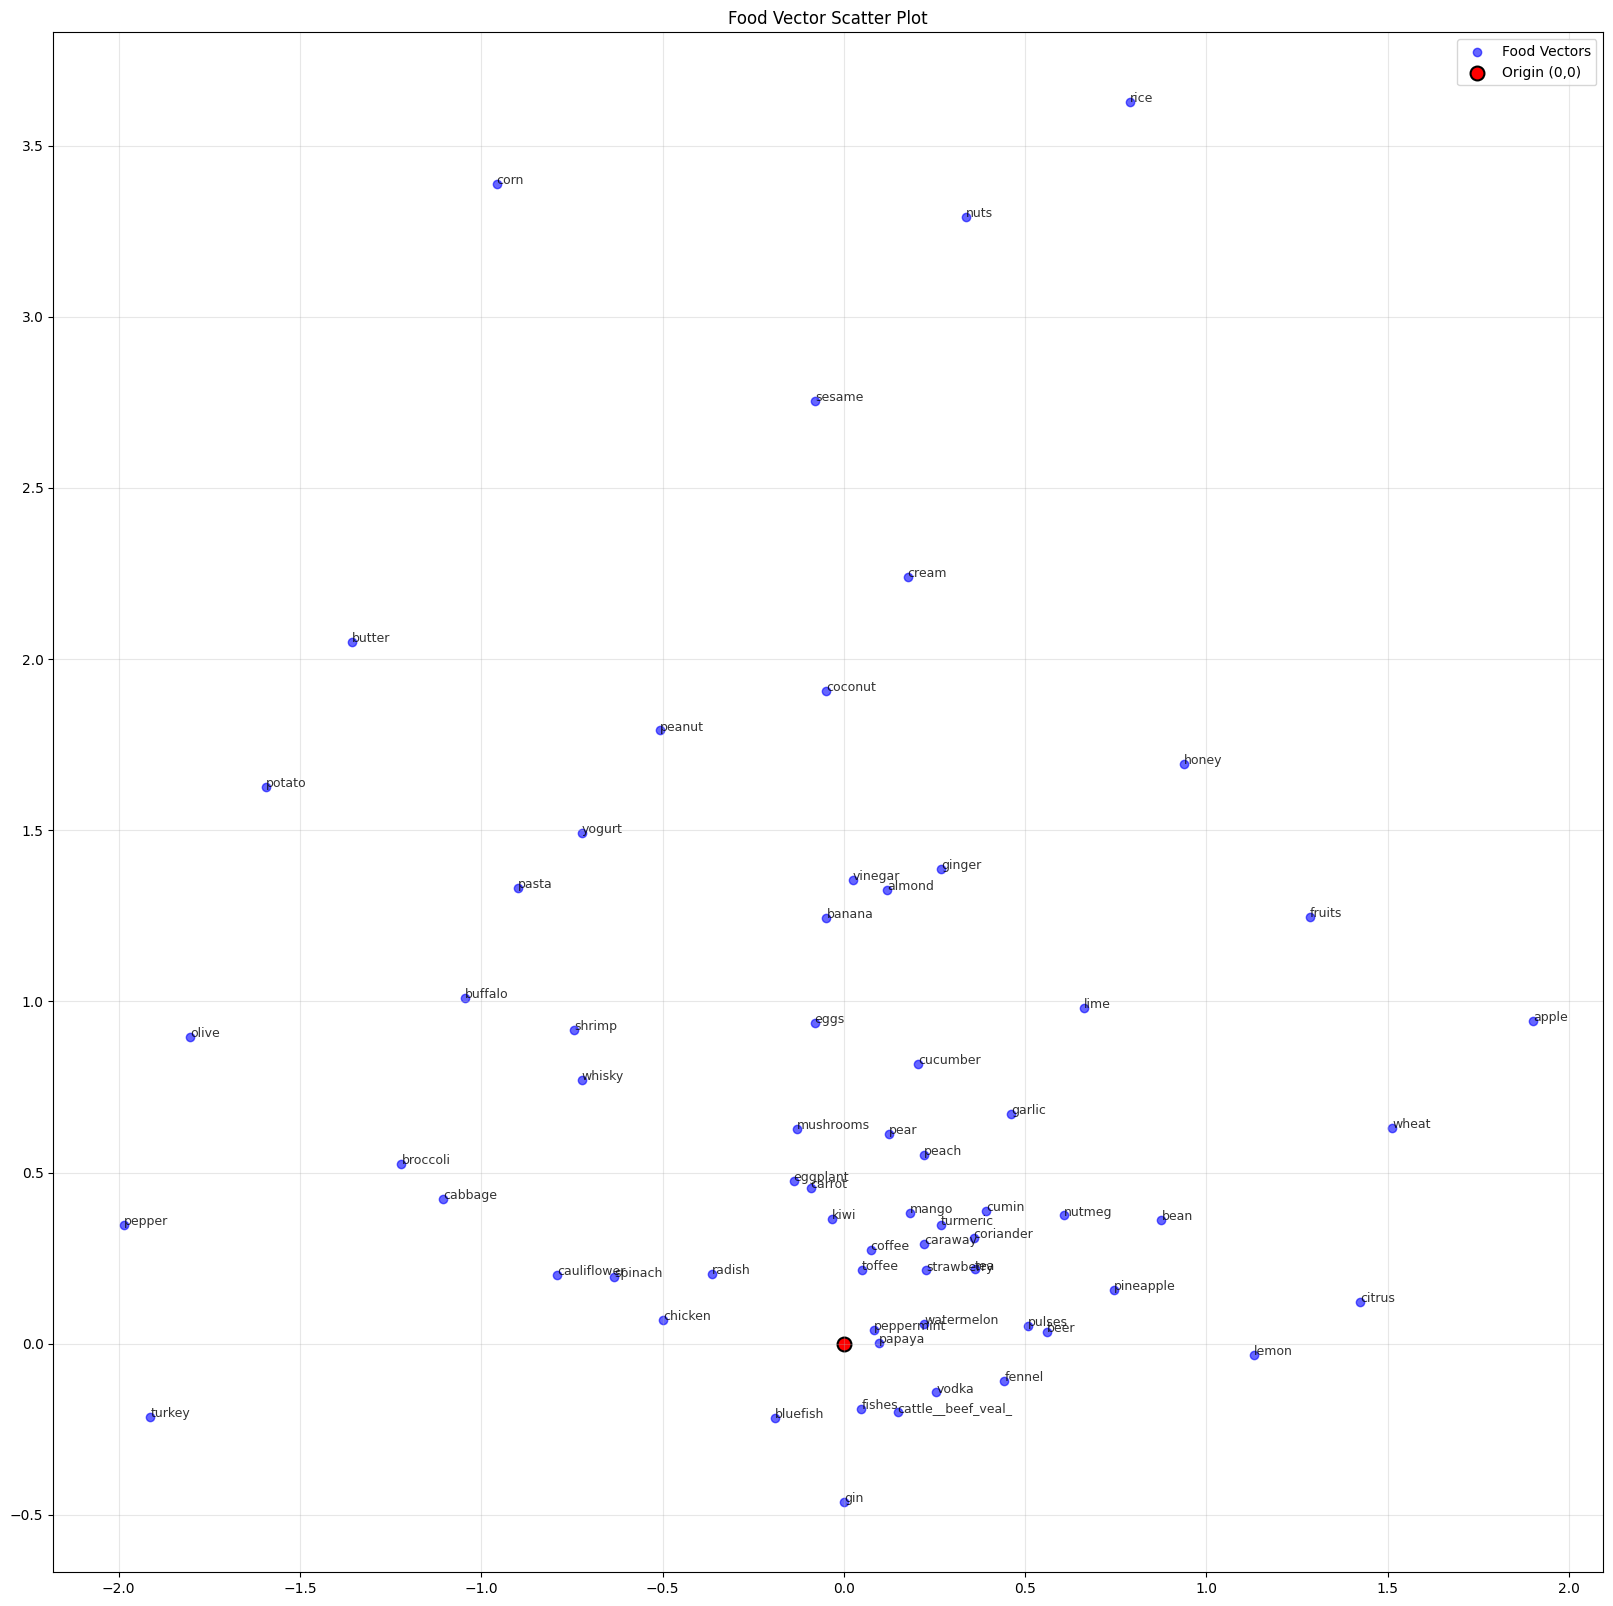

In [ ]:
show_items = ['kiwi','garlic','pineapple','peanut','cattle__beef_veal_','chicken','cauliflower','broccoli',
'tea','pepper','papaya','caraway','watermelon','lime','lemon','coffee','coriander','cucumber',
'cumin','turmeric','fennel','strawberry','apple','mango','peppermint','nutmeg','olive','rice',
'almond','peach','pear','radish','sesame','eggplant','potato','spinach','corn','ginger','banana',
'carrot','beer','pasta','bluefish','buffalo','coconut','turkey','shrimp','wheat','eggs','yogurt',
'bean','vodka','whisky','gin','honey','vinegar','toffee','butter','cream','cabbage','mushrooms',
'citrus','fishes','pulses','nuts','fruits']

def find_food(tx):
    # クエリ実行と結果の取得
    return tx.run("MATCH (f:Food) RETURN f").data()

vectors = []
labels = []

with driver.session() as session:
    # クエリ結果をループ処理
    foods = session.execute_read(find_food)
    for i, record in enumerate(foods):
        vec = np.array(record["f"]["word_vector"])
        if record["f"]["id"] in show_items:
            vectors.append(vec)            
            labels.append((vec[:2], record["f"]["id"]))
            
vectors = np.array(vectors)
# 散布図をプロット
plt.figure(figsize=(20, 20))
plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6, c="blue", label="Food Vectors")

# ラベルをプロット（10個に1つだけ）
for (x, y), label in labels:
    plt.text(x, y, label, fontsize=9, alpha=0.8)
    
plt.scatter(0, 0, c="red", s=100, label="Origin (0,0)", edgecolors="black", linewidth=1.5)
plt.title("Food Vector Scatter Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### similarityの可視化

In [ ]:
def project_similarity_graph(tx):
    tx.run("""
        CALL gds.graph.list() 
        YIELD graphName WITH graphName 
        WHERE graphName = 'kmeansGraph' 
        CALL gds.graph.drop('kmeansGraph') 
        YIELD graphName AS droppedGraph RETURN droppedGraph;
    """)
    tx.run("""
        CALL gds.graph.project(
            'kmeansGraph',
            {
                Food: {
                    properties: ['word_vector', 'flavor_vector']
                }
            },
            {
                CONTAINS: {
                    orientation: 'UNDIRECTED'
                }
            }
        );
     """)
    
def fetch_pagerank_and_edges():
    # Word2Vecのクラスタリングを取得
    word_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'word_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    # Flavorのクラスタリングを取得
    flavor_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'flavor_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, node.display_name_ja as display_name_ja, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    with driver.session() as session:
        session.write_transaction(project_similarity_graph)
        word_result = session.run(word_query)
        flavor_result = session.run(flavor_query)
        
        word_df = pd.DataFrame([dict(record) for record in word_result])
        flavor_df = pd.DataFrame([dict(record) for record in flavor_result])
        
    return word_df, flavor_df

# データ取得
word_df, flavor_df = fetch_pagerank_and_edges()


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_99991/1744557776.py:57: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(project_similarity_graph)


In [ ]:
word_df.tail(3)
word_df.to_csv('../tmp/word_df.csv')

In [ ]:
flavor_df.tail(3)
flavor_df.to_csv('../tmp/flavor_df.csv')

In [ ]:
# wordでもflavorでも同じコミュニティに属している組み合わせのidをリストに追加する
tt_list = []

# word_dfを1件づつ検査する
for i, row in word_df.iterrows():
    same_list = []
    food_id = row['id']
    community_id = row['communityId']
    same_community_ids = (flavor_df[flavor_df['communityId'] == community_id])['id'].values
    flavor_row = flavor_df[flavor_df['id'] == food_id]
    
    # 取得したcommunityIdと同じcommunityIdの行をflavor_dfから抽出する
    community_rows = flavor_df[flavor_df['communityId'] == flavor_row["communityId"].values[0]]
    
    for j, f_row in community_rows.iterrows():
        if f_row['id'] in same_community_ids:
            same_list.append((f"{f_row['id']}: {f_row['display_name_ja']}"))
            
    if same_list is not None and len(same_list) > 0:
        tt_list.append(same_list)

matched = pd.DataFrame(tt_list)
matched.transpose()
matched.transpose().to_csv('../tmp/matched.csv')

## 因果分析